In [0]:

import keras
from keras.models import Sequential
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from keras.layers import Embedding, Input, LSTM, TimeDistributed, Dense
from keras.utils import plot_model
from keras.models import Model
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import json
import random
import csv


class DataGenerator(keras.utils.Sequence):
    
    def someFunction(self,list_IDs_temp):
        return self.__data_generation(list_IDs_temp)
        
    'Generates data for Keras'
    def __init__(self, list_IDs, image_embedding, captions, batch_size=32,num_caption = 92, caption_dim =300, image_dim=(2048), n_channels=1, shuffle=True):
        'Initialization'
        self.image_dim = image_dim
        self.caption_dim = caption_dim
        self.num_caption = num_caption
        self.batch_size = batch_size
        self.list_IDs = list_IDs
#         self.n_channels = n_channels
        self.shuffle = shuffle
        self.image_embedding = image_embedding
        self.captions = captions
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.image_dim))
        Y = np.empty((self.batch_size, self.num_caption, self.caption_dim ))
        
        for i, ID in enumerate(list_IDs_temp):
            X[i,] = self.image_embedding[ID]
            Y[i] = self.captions[ID]

        return X, Y

In [0]:


SEED = 10
IMAGE_EMBEDDING_DIR = 'image_embeddings.json'
NUM_IMAGE_EMBEDDING_CHUNKS = 2
GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.300d.txt'
CAPTION_FILE_NAME = 'image_to_captions.csv'
MAX_SEQUENCE_LENGTH = 92
WORD_EMBEDDING_DIM = 300

BATCH_SIZE = 64
EPOCHS = 10

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Labels
file_id = '1NpLC7ApLS32X0ZHxmbhRmBNKZhNtO8aV'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('labels.json')

# GloVe
file_id = '1PqAbS3dSf7qdwYHD9fuH8aAt4eONpnlX'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('glove.6B.300d.txt')

# Image embeddings
file_id = '1kAvj8Yfu65Ut-I5P9DXx4CRjnsAXfwm_'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('image_embeddings_old.json')

# Image to story csv file
file_id = '1ZGnhD3uH5mJqAC6aXdfzOPBKWI4_DdYg'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('image_to_captions.csv')

In [0]:

class text_encoder:
    def get_embedding_matrix(self,filename, WORD_EMBEDDING_DIM):
        embeddings_index = {}
        word_to_index = {}

        with open(filename) as f:
            for index, line in enumerate(f):
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
                word_to_index[word] = index

          # Vocabulary
        vocabulary = embeddings_index.keys()
        embedding_matrix = np.zeros((len(vocabulary) + 1, WORD_EMBEDDING_DIM))

        for word, i in word_to_index.items():
            embedding_vector = embeddings_index[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

        return embedding_matrix, vocabulary, word_to_index
    
    def load_embeddings(self):
        embedding_matrix, vocabulary, word_to_index = self.get_embedding_matrix(GLOVE_EMBEDDING_FILE_NAME, WORD_EMBEDDING_DIM)      
        self.embedding_matrix = embedding_matrix
        self.vocabulary = vocabulary
        self.word_to_index = word_to_index
        
    def get_sentence_embedding(self,sentence):
        words = sentence.split()    
        sentence_embedding =  np.zeros(shape=(MAX_SEQUENCE_LENGTH,WORD_EMBEDDING_DIM))
        mask =  np.zeros(MAX_SEQUENCE_LENGTH)
        i=0;
        for w in words:
            mask[i] = 1
            index = self.word_to_index.get(w,-1)
            if(index != -1):
                sentence_embedding[i] = self.embedding_matrix[index]
            else:
                sentence_embedding[i] = np.zeros(WORD_EMBEDDING_DIM)
            i+=1       
        return  sentence_embedding, mask

In [0]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

In [0]:
def getImageEmbedding():
        image_embedding = {}
    #for i in range (NUM_IMAGE_EMBEDDING_CHUNKS):
        file_name = IMAGE_EMBEDDING_DIR# + 'group_'+str(i+1)+'.json'
        with open(file_name) as json_file:
            print(file_name)
            json_data = json.load(json_file)
            json_data = json.loads(json_data)
            image_embedding = Merge(image_embedding, json_data) 
        return image_embedding

In [0]:
def getCaptions(id_list,text_ebmd_encoder):
    caption_dict = {}
    with open(CAPTION_FILE_NAME) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if row[1] in id_list:
#                  print(row[1] +"  "+ row[2])
                 embd, mask = text_ebmd_encoder.get_sentence_embedding(row[2])
                 caption_dict[row[1]] = embd
#                  print( caption_dict[row[1]])

    return caption_dict

In [0]:
def getPartitions(image_list_file_name):
    with open(image_list_file_name) as json_file:
        json_data = json.load(json_file)
#         json_data = json.loads(data)
        print(len(json_data))
        return json_data

In [60]:
# Parameters
random.seed(SEED)

params = {'num_caption': 92,
          'caption_dim' :300,
          'image_dim' : 2048,
          'batch_size': BATCH_SIZE,
          'shuffle': True}

# ids = getPartitions('image_embeddings.json')
# random.shuffle(ids)

# id_len = len(ids)
# partition = {}

# partition['train'] = ids[:int((id_len+1)*.90)] #Remaining 90% to training set
# partition['validation'] = ids[int(id_len*.90+1):] #Splits 10% data to test set

# print(len(partition['train']))
# print(len(partition['validation']))

image_embedding = getImageEmbedding()

ids = list(image_embedding.keys())
id_len = len(ids)
partition = {}
partition['train'] = ids[:int((id_len+1)*.90)] #Remaining 90% to training set
partition['validation'] = ids[int(id_len*.90+1):] #Splits 10% data to test set

text_ebmd_encoder = text_encoder()
text_ebmd_encoder.load_embeddings()
captions = getCaptions(image_embedding.keys(),text_ebmd_encoder);


training_generator = DataGenerator(partition['train'], image_embedding, captions , **params)
validation_generator = DataGenerator(partition['validation'], image_embedding, captions, **params)

id_filtered = list(image_embedding.keys())
x =id_filtered[:64]
train_X, train_Y = training_generator.someFunction(x)
print(train_X.shape)
print(train_Y.shape)


image_embeddings.json
(64, 2048)
(64, 92, 300)


In [0]:
def get_embedding_matrix(filename, EMBEDDING_DIM):

  embeddings_index = {}
  word_to_index = {}
  
  with open(filename) as f:

    for index, line in enumerate(f):

      values = line.split()

      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')

      embeddings_index[word] = coefs
      word_to_index[word] = index

  # Vocabulary
  vocabulary = embeddings_index.keys()

  embedding_matrix = np.zeros((len(vocabulary) , EMBEDDING_DIM))

  for word, i in word_to_index.items():

    embedding_vector = embeddings_index[word] #word embedding
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  return embedding_matrix, vocabulary, word_to_index

embedding_matrix, vocabulary, word_to_index = get_embedding_matrix(GLOVE_EMBEDDING_FILE_NAME, WORD_EMBEDDING_DIM)

In [50]:
print(np.shape(embedding_matrix))

(400000, 300)


#Model

In [0]:
def image_caption_model(embedding_matrix, MAX_LEN=10, EMBEDDING_DIM=300, HIDDEN_DIM=300):
    
    embedding_layer = Embedding(len(word_to_index),
                                WORD_EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_LEN,
                                trainable=False,
                                name="Embedding")

    state_h = K.variable(value=np.zeros((BATCH_SIZE, HIDDEN_DIM)))
    state_c = K.variable(value=np.zeros((BATCH_SIZE, HIDDEN_DIM)))

    decoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32', name="decoder_input")
    decoder_embedding = embedding_layer(decoder_inputs)

    decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True, name="LSTM")
    decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])
    
    #outputs = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))(decoder_outputs)
    #model = Model([encoder_inputs, decoder_inputs], outputs)
    model = Model(decoder_inputs, decoder_outputs)

    return model

In [0]:
# from keras.layers import Embedding

# embedding_layer = Embedding(len(word_index),
#                                 EMBEDDING_DIM,
#                                 weights=[embedding_matrix],
#                                 input_length=MAX_LEN,
#                                 trainable=True,
#                                 name="Embedding")

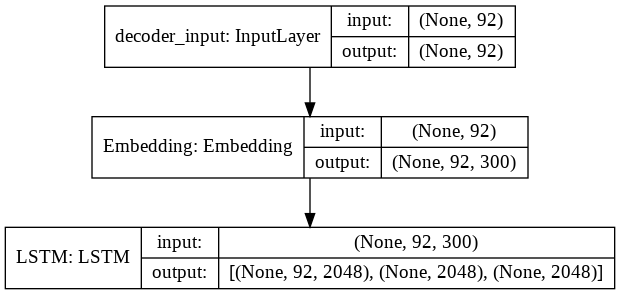

In [62]:
model = image_caption_model(embedding_matrix, MAX_LEN=MAX_SEQUENCE_LENGTH, HIDDEN_DIM=2048)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def euclidean_distance_loss(yTrue,yPred):
    return K.sqrt(K.sum(K.square(yPred - yTrue), axis=-1))


model.compile(
    optimizer='adam',
    loss=euclidean_distance_loss,
    metrics=['accuracy']
)

In [64]:
model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=1, 
    verbose=1
    
)

Epoch 1/1


ValueError: ignored

In [58]:
with open("imgaes_with_ca")

["2627795780", "2626979987", "2626982337", "2626983575", "2626985925", "2701863545", "2626977325", "205866755", "205862590", "204092716", "205858578", "204095815", "203187193", "205858625", "997622638", "997623170", "997624052", "996779457", "996785737", "997623674", "997629588", "2385391331", "2385461955", "2387709159", "2387731867", "2388583308", "2386289908", "2388512800", "2387719253", "2387735207", "182307006", "189264495", "180526610", "183370950", "191457571", "182421476", "190620212", "180526609", "181603598", "181604220", "181606097", "181630617", "181641817", "181647714", "181626113", "181645575", "181635518", "181640606", "182032412", "182032576", "182032639", "182032661", "182032379", "182032528", "182032720", "182023789", "182023792", "182023793", "182030838", "182023794", "182116680", "182117151", "182116919", "182117489", "182118143", "182117236", "182117993", "182117058", "182152255", "182152324", "182153079", "182153243", "182153283", "182152507", "182152600", "1821527